## Figure 5 - Observation of ALOS-2 on Shinmoe-dake and Iwo-yama

In [14]:
%matplotlib inline
import os
import numpy as np
from datetime import timedelta, datetime as dt
from matplotlib.gridspec import GridSpec
from matplotlib import pyplot as plt, ticker, dates as mdates
from mintpy.defaults.plot import *
from mintpy.utils import ptime, readfile, utils as ut, plot as pp
from mintpy.objects import timeseries
from mintpy import view, tsview

work_dir = os.path.expanduser('~/Documents/Paper/2019_Kirishima/figs_src/obs_ALOS2')
os.chdir(work_dir)
print('Go to directory:', work_dir)

data_dir = os.path.expanduser('~/insarlab/Kirishima/KirishimaAlos2DT23/mintpy')
ts_file = os.path.join(data_dir, 'timeseries_ERA5_ramp_demErr.h5')
dem_file = os.path.join(data_dir, 'inputs/gsi10m.dem.wgs84')
vel_file = os.path.join(data_dir, 'velocity.h5')
atr = readfile.read_attribute(vel_file)
unw_file = os.path.join(data_dir, '{}.unw'.format(atr['DATE12']))

lalo_iwo = [31.9502, 130.8548]
lalo_shinmoe = [31.9176, 130.8889]
lalo_ref = [31.9296, 130.8522] #[31.9172, 130.8472]
lalo_list = [lalo_ref, lalo_shinmoe, lalo_iwo]

phase2range = -1 * float(atr['WAVELENGTH']) / (4 * np.pi)
unw = readfile.read(unw_file)[0] * phase2range * 100. #cm
coord = ut.coordinate(atr)
y, x  = coord.geo2radar(lalo_iwo[0], lalo_iwo[1])[0:2]
print('cumulative displacement at Iwo-yama: {:.1f} cm'.format(unw[y, x]))
y, x  = coord.geo2radar(lalo_shinmoe[0], lalo_shinmoe[1])[0:2]
print('cumulative displacement at Shinmoe-dake: {:.1f} cm'.format(unw[y, x]))

# inversion result for the 2017pre
inv_file_2017pre = os.path.expanduser('~/insarlab/Kirishima/Model/Shinmoe2017pre/invert_1_T/KirishimaAlos2DT23_20150209_20170918.h5')
inv_atr_2017pre = readfile.read_attribute(inv_file_2017pre)
inv_lat_2017pre = float(inv_atr_2017pre['MCTG_LAT'])
inv_lon_2017pre = float(inv_atr_2017pre['MCTG_LON'])
# inversion result for the 2008post
inv_file_2008post = os.path.expanduser('~/insarlab/Kirishima/Model/Shinmoe2008post/invert_1_2_C/ShinmoeAlosDT73_20081012_20100302.h5')
inv_atr_2008post = readfile.read_attribute(inv_file_2008post)
inv_lat_2008post = float(inv_atr_2008post['CDMN_LAT'])
inv_lon_2008post = float(inv_atr_2008post['CDMN_LON'])

Go to directory: /Users/yunjunz/Documents/Paper/2019_Kirishima/figs_src/obs_ALOS2
cumulative displacement at Iwo-yama: 11.8 cm
cumulative displacement at Shinmoe-dake: 3.7 cm


save figure to file /Users/yunjunz/Documents/Paper/2019_Kirishima/figs_src/obs_ALOS2/dis_map.png


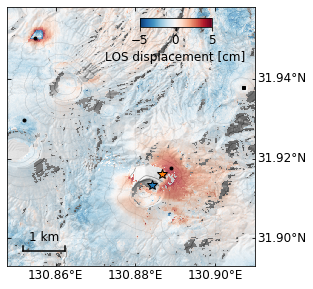

In [24]:
## Plot velocity map
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[4, 4])

opt = ' --sub-lat 31.893 31.958 --sub-lon 130.848 130.91 '
opt += '--dem {} --contour-step 100 --contour-smooth 0.0 '.format(dem_file)
opt += ' -c RdBu_r --wrap --wrap-range -5 5 -u cm '
opt += ' --notitle --fontsize 12 --ref-size 3 --lalo-step 0.02 --nocbar --alpha 0.7 '
opt += ' --lalo-loc 0 1 0 1'
opt += ' --scalebar 0.25 0.15 0.06 --scalebar-pad 0.05 '
opt += ' --noverbose --shade-az 315 '

# velocity map with DEM background
cmd = 'view.py {f} {o}'.format(f=unw_file, o=opt)
data, atr, inps = view.prep_slice(cmd)
ax, inps, im, cbar = view.plot_slice(ax, data, atr, inps)

# point of interest
ax.plot(lalo_list[0][1], lalo_list[0][0], "k.", mew=1., ms=6)
ax.plot(lalo_list[1][1], lalo_list[1][0], "k.", mew=1., ms=6)
ax.plot(lalo_list[2][1], lalo_list[2][0], "k.", mew=1., ms=6)

# optimal model location
ax.plot(inv_lon_2017pre, inv_lat_2017pre, 'k*', mfc=pp.mplColors[1], ms=10, linewidth=0.5, fillstyle='full')  #for the 2017 eruption
ax.plot(inv_lon_2008post, inv_lat_2008post, 'k*', mfc=pp.mplColors[0], ms=10, linewidth=0.5, fillstyle='full')  #for the 2017 eruption

fig.subplots_adjust(wspace=0.05, left=0.05, right=0.95, top=0.95, bottom=0.05)

# colorbar
#cax = fig.add_axes([0.1, 0.08, 0.03, 0.4])
cax = fig.add_axes([0.53, 0.88, 0.25, 0.03])
cbar = plt.colorbar(im, cax=cax, orientation='horizontal')#, ticks=[-2.5, 0, 2.5])
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('LOS displacement [cm]', fontsize=font_size)

# output
out_file = os.path.abspath('dis_map.png')
plt.savefig(out_file, bbox_inches='tight', transparent=True, dpi=fig_dpi)
print('save figure to file', out_file)
plt.show()

In [3]:
## Read displacement time-series at points of interest
obj = timeseries(ts_file)
obj.open()
dates = obj.times
ex_dates = ptime.date_list2vector(ptime.read_date_list(os.path.join(data_dir, 'exclude_date.txt')))[0]
keep_dates = sorted(list(set(dates) - set(ex_dates)))

dis_list = []
for lalo in lalo_list:
    dis = ut.read_timeseries_lalo(lalo[0], lalo[1], ts_file, unit='cm', print_msg=False)[1]
    dis_list.append(dis)

open timeseries file: timeseries_ERA5_ramp_demErr.h5


save figure to file /Users/yunjunz/Documents/Paper/2019_Kirishima/figs_src/obs_ALOS2/dis_ts.png


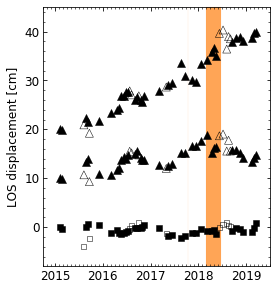

In [29]:
## Plot displacement time-series at points of interest
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[3.5, 4])

## Displacement time-series
off = 10
markersizes = [3,4,4]
m_list = ['s', '^', '^']
for i in range(len(dis_list)):
    dis = dis_list[i] + off * i
    m = m_list[i]
    s = markersizes[i]
    for dti in ex_dates:
        ax.scatter(dti, dis[dates==dti], marker=m, edgecolor='k', facecolors='none', s=s**3, linewidths=0.5)
    for dti in keep_dates:
        ax.scatter(dti, dis[dates==dti], marker=m, edgecolor='k', facecolors='k', s=s**3, linewidths=0.5)


# eruptive dates
dates_2017 = ptime.date_list2vector(['20171011', '20171017'])[0]
dates_2018 = ptime.date_list2vector(['20180301', '20180627'])[0]
for dts in [dates_2017, dates_2018]:
    ax.axvspan(xmin=dts[0], xmax=dts[1], color=pp.mplColors[1], linestyle='-', linewidth=0.1, zorder=0, alpha=0.7, clip_on=False)

# axes format
#ax.yaxis.tick_right()
#ax.yaxis.set_label_position("right")
ax.tick_params(which='both', direction='in', labelsize=font_size, bottom=True, top=True, left=True, right=True)
pp.auto_adjust_xaxis_date(ax, dates)
ax.xaxis.set_minor_locator(mdates.MonthLocator())
ax.yaxis.set_minor_locator(ticker.AutoMinorLocator(5))
ax.set_xlim(dt(2014, 10, 1), dt(2019, 7, 1))
ax.set_ylim(-8, 45)
ax.set_ylabel('LOS displacement [cm]', fontsize=font_size)
fig.subplots_adjust(wspace=0.05, hspace=0.1, left=0.05, right=0.95, top=0.95, bottom=0.05)

# output
out_file = os.path.abspath('dis_ts.png')
plt.savefig(out_file, bbox_inches='tight', transparent=True, dpi=fig_dpi)
print('save figure to file', out_file)
plt.show()

### Finding Points of Interests

tsview.py /Users/yunjunz/insarlab/Kirishima/KirishimaAlos2DT23/mintpy/timeseries_ERA5_ramp_demErr.h5 --dem /Users/yunjunz/insarlab/Kirishima/KirishimaAlos2DT23/mintpy/inputs/gsi10m.dem.wgs84 --wrap --wrap-range -5 5 --ref-date 20150223 -n 20 --ylim -5 10 --lalo 31.9176 130.8889
open timeseries file: timeseries_ERA5_ramp_demErr.h5
No lookup table info range/lat found in files.
data   coverage in y/x: (0, 0, 541, 541)
subset coverage in y/x: (0, 0, 541, 541)
data   coverage in lat/lon: (130.81990740749998, 31.9800925925, 130.92009249249998, 31.8799075075)
subset coverage in lat/lon: (130.81990740749998, 31.9800925925, 130.92009249249998, 31.8799075075)
------------------------------------------------------------------------
reading timeseries from file /Users/yunjunz/insarlab/Kirishima/KirishimaAlos2DT23/mintpy/timeseries_ERA5_ramp_demErr.h5 ...
reference to pixel: (227, 470)
reference to date: 20150223
read mask from file: maskTempCoh.h5
data    range: [-19.17351, 26.740307] cm
display 

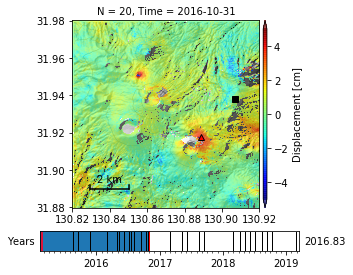

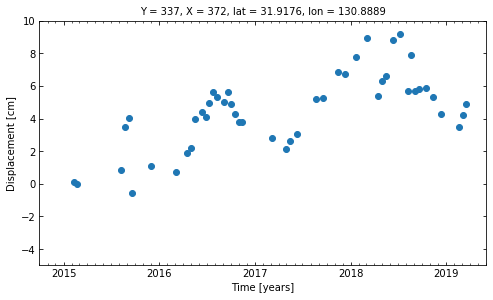

In [14]:
cmd = '{} --dem {} --wrap --wrap-range -5 5 --ref-date 20150223 -n 20 '.format(ts_file, dem_file)
cmd += ' --ylim -5 10 --lalo 31.9176 130.8889 '
tsview.main(cmd.split())